# Исследовательский анализ продаж компьютерных игр для интернет-магазина

В нашем распоряжении данные, предоставленные интернет-магазином «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). В ходе исследования данных необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед нами данные до 2016 года. Нужно проанализировать имеющиеся исторические данные, чтобы спланировать кампанию на 2017 год. 
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

План работ следующий:
- загрузка и ознакомление с файлом
- предобработка данных
- исследовательский анализ данных (выявление лидеров продаж, определение актуального периода для прогноза, определение платформ лидеров, анализ влияния оценок критиков и пользователей на продажи, распределение игр по жанрам)
- построение портрета пользователя каждого региона
- проверка гипотез

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import warnings

In [2]:
#suppress warnings
warnings.filterwarnings('ignore')

#### Шаг 1. Загрузка данных

In [3]:
try:
    df = pd.read_csv('/datasets/games.csv')
except:
    df = pd.read_csv('games.csv')

In [4]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод по шагу 1.** Из общей информации видно, что файл содержит 16715 строк по продажам различных компьютерных игр в различных регионах. В некоторых столбца (например, Year_of_Release, Critic_Score и п.т.) есть пропуски. По некоторым столбцам (например, Year_of_Release) неверно определен тип данных, а также в наименованиях столбцов встречаются строчные и заглавные буквы. Займемся обработкой обнаруженных недочетов в следующем шаге.

#### Шаг 2. Подготовка данных (предобработка)

In [6]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [7]:
df.duplicated().sum()

0

In [8]:
df.loc[df.duplicated(subset = ['name', 'platform', 'year_of_release'], keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


Обнаружено 4 неявных дубликата, удалим их из нашего датафрейма, продажи по дубликатам минимальны, так что удаление не повлияет на результаты дальнейшего исследования.

In [9]:
df = df.drop_duplicates(subset = ['name', 'platform', 'year_of_release'], keep='first')
df.duplicated(subset = ['name', 'platform', 'year_of_release'], keep=False).sum()

0

In [10]:
df.isna().sum()

name                  1
platform              0
year_of_release     269
genre                 1
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8577
user_score         6700
rating             6765
dtype: int64

In [11]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.0,0.08,NaN,NaN,NaN


In [12]:
df.dropna (subset=['name'], inplace=True)
df.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

Мы видим, что продажи по игре без названия минимальные, рейтинги по ней отсутствуют. Можем ее удалить, это не повлияет на результаты дальнейшего исследования.

В столбце 'year_of_release' 269 пропусков. Т.к. мы не знаем точно в каком году какая игра вышла, то оставим эти пропуски, как есть. Заменим тип данных на int.

In [13]:
df['year_of_release'] = df['year_of_release'].astype('Int64')

В столбце critic_score 8577 пропусков, тип данных float64. В этом столбце дается оценка игры критиками (максимум 100 баллов), отсутствие рейтинга свидетельствует о том, что она еще не была оценена критиками (возможно недавно вышла). В данном случае заменить оценку на 0 мы не можем, т.к. это будет говорить, что у игры очень низкий рейтинг, что не соответствует действительности, остается оставить пропуски, как есть.

В столбце user_score 6700 пропусков, тип данных object. В этом столбце дается оценка игры пользователями (максимум 10 баллов), значит тип данных должен быть float, а не object. Выведем уникальные значения по столбцу user_score, чтобы понять, что повлияло на то, что тип данных определен неверно.

In [14]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Помимо числовых значений в столце 'user_score', встречается значение 'tbd'. В сфере компьютерных игр сокращение 'tbd' означает to be determined, то есть "Будет определено". Значит в нашем датасете 'tbd' допустимо заменить на NaN. Тип данных надо заменить на float.

In [15]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['user_score'] = df['user_score'].astype('float')

# Проверим замену tbd на nan
df['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

В столбце rating 6765 пропусков. Если рейтинг отсутствует, то он скорее всего не определен, заменим пропуски на undefined.

In [16]:
df['rating'] = df['rating'].fillna('undefined')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16712 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16712 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16712 non-null  object 
 4   na_sales         16712 non-null  float64
 5   eu_sales         16712 non-null  float64
 6   jp_sales         16712 non-null  float64
 7   other_sales      16712 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       7589 non-null   float64
 10  rating           16712 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


Посчитаем суммарные продажи каждой игры на той или иной платформе по всем регионам.

In [18]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,undefined,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,undefined,31.38


**Выводы по шагу 2.** В ходе предобработки данных были проанализированы данные на наличие дубликатов, пропусков и корректности указания типов данных. Явные дубликаты не были обнаружены. Проверка на неявные дубликаты выявила 4 строки с дублями по столбцам с название игры, платформы и годом выхода. Строки с неявными дубликатами были удалены. Строка с пропусками в столбцах name и genre была удалена. Пропуски по столбцам с рейтингами оставили как есть, так как нет адекватной методики, согласно которой их можно было бы заменить, удалять строки с пропусками нельзя т.к. отсутствие рейтинга само по себе является важной характеристикой игры, к тому же мы бы потеряли значительную часть датасета. Скорее всего пропуски в столбцах с рейтингами образовались из-за того, что не по всем играм в открытых источниках есть данные, вероятно критики и пользователи еще не успели дать оценку той или иной игре (т.к. игра новая), либо игра непопулярная и не попала ни в один из рейтингов.  В столбце rating отображаются категориальные значения, по нему пропуски заменили на 'undifend'. Что касается типов данных, то они были скорректированы у столбцов year_of_release, user_score.

#### Шаг 3. Исследовательский анализ данных

##### Шаг 3.1 Выпуск игр в разные годы

Посмотрим, сколько игр выпускалось в разные годы. Для этого построим столбчатую диаграмму, где по оси х отразим годы, а по оси y - количество игр, чей релиз вышел в том или ином году.

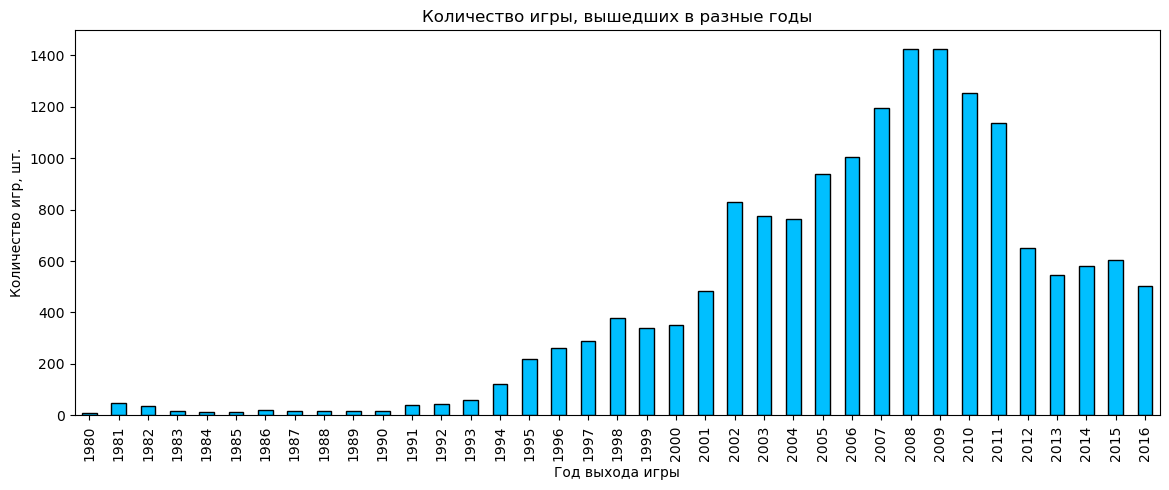

In [20]:
df.groupby('year_of_release')['name'].count().plot(kind='bar', y='name', figsize=(14,5), ec='black', color= 'deepskyblue');
plt.title('Количество игры, вышедших в разные годы')
plt.ylabel('Количество игр, шт.')
plt.xlabel('Год выхода игры')
plt.show()

На графике хорошо видно, что с 1980 по 1993 годы выходило малое количество игр, что, вероятно, связано с неразвитостью технологий, компьютеров, а также их малой доступностью простым пользователям. С 1994 года начинается устойчивый и довольно резкий рост количества выпускаемых игр в год. Рост достигает своего пика в 2008 году, после чего происходит спад вплоть до 2016 года. Возможно спад связан с развитием мобильных технологий, а также социальных сетей, которые перетянули на себя внимание потенциальных пользователей, соответственно компьютерных игр на игровых платформах стали выпускать меньше.

##### Шаг 3.2 Распределение продаж игр на разных платформах

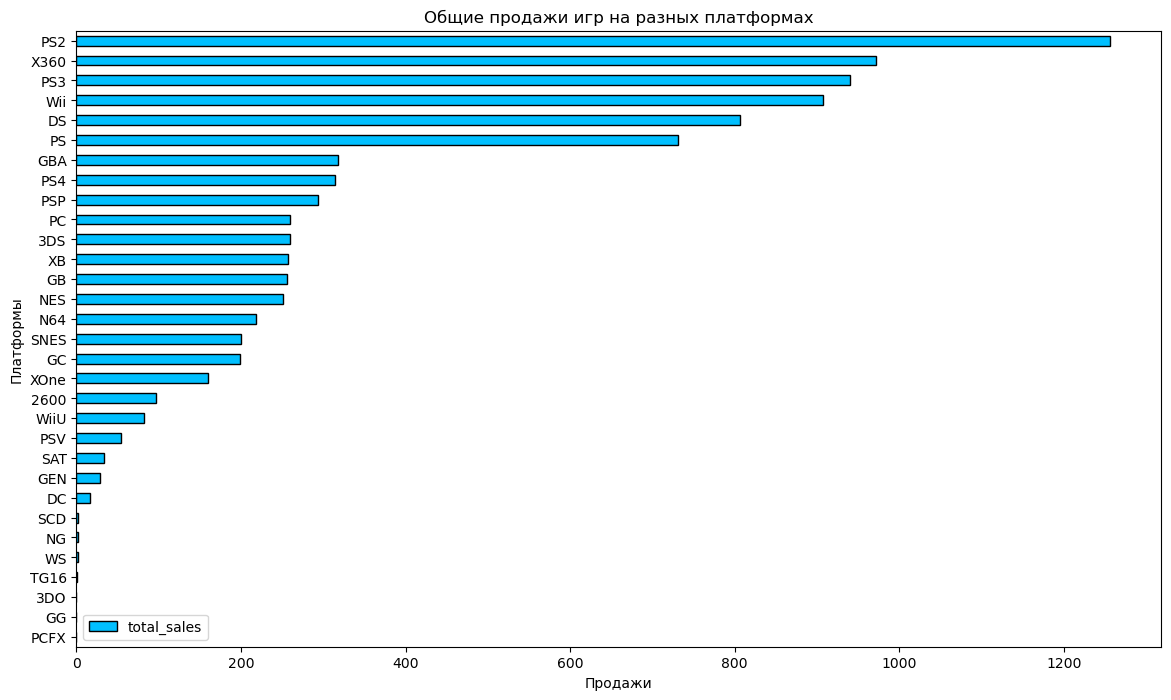

In [21]:
(df.groupby('platform')['total_sales']
.sum()
.reset_index()
.sort_values(by= 'total_sales')
.plot(kind='barh',x = 'platform', y='total_sales', figsize=(14,8), ec='black', color= 'deepskyblue'))

plt.title('Общие продажи игр на разных платформах')
plt.ylabel('Платформы')
plt.xlabel('Продажи')
plt.show()

In [22]:
df_hp = df.groupby('platform')['total_sales'].sum().reset_index().sort_values(by= 'total_sales', ascending = False).head(6)
df_hp.reset_index(drop=True)
df_hp

,platform,total_sales
16,PS2,1255.77
28,X360,971.42
17,PS3,939.64
26,Wii,907.51
4,DS,806.12
15,PS,730.86


Запишем в отдельную переменную Топ-6 платформ.

In [23]:
top_pl  = df_hp['platform'].unique()
top_pl

array(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'], dtype=object)

Построим график, на котором отразим продажи платформ из сформированного списка Топ-6 по годам. Ранее мы выяснили, что с 1995 года начался активный рост числа выпускаемых игр, поэтому график будем строить, начиная с этого периода.

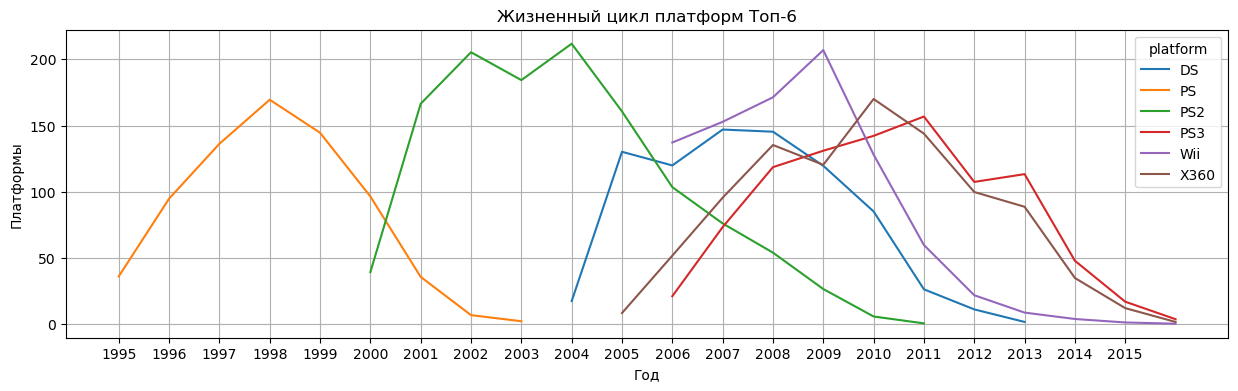

In [24]:
(df.query('platform in @top_pl and year_of_release > 1994')
 .pivot_table(index='year_of_release', columns = 'platform', values='total_sales', aggfunc='sum')
 .plot(figsize=(15, 4)));
plt.grid(True)
plt.title('Жизненный цикл платформ Топ-6')
plt.ylabel('Платформы')
plt.xlabel('Год')
plt.xticks(np.arange(1995,2016,1));

На графике хорошо видны жизненные циклы каждой из платформ Топ-6: резкий рост продаж в начале жизненного цикла в течении 3-4 лет, затем достижение пика и плавный спад на протяжение 6-8 лет.

In [25]:
df_time = df.groupby('platform')['year_of_release'].agg(['min','max']).reset_index()
df_time['delta'] = df_time['max'] - df_time['min'] + 1
print('Медианное значение жизненного цикла игр', round(df_time['delta'].median(),0),'лет')

Медианное значение жизненного цикла игр 7.0 лет


##### Шаг 3.3 Определение актуального периода

Для дальнейшего исследования нам необходимо определить **актуальный период**, т.е. тот период, данные из которого мы будем использовать для прогноза на 2017 год.<br/>
Анализируя график "Количество игры, вышедших в разные годы" мы видим рост до 2008 года, затем спад до 2012 года, а начиная с 2013 года стабилизация и новый небольшой рост. Считаю, что период с 2013 года актуальный и наиболее подходящий для дальнейшего исследования и прогноза на 2017 год.<br/>
Создадим новый датафрейм df_act для актуальных данных.

In [26]:
df_act = df.query('year_of_release >= 2013')
df_act.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,undefined,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,undefined,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


Используя датафрейм с актуальными данными, посмотрим на графике, какой доход приносили платформы за все годы.

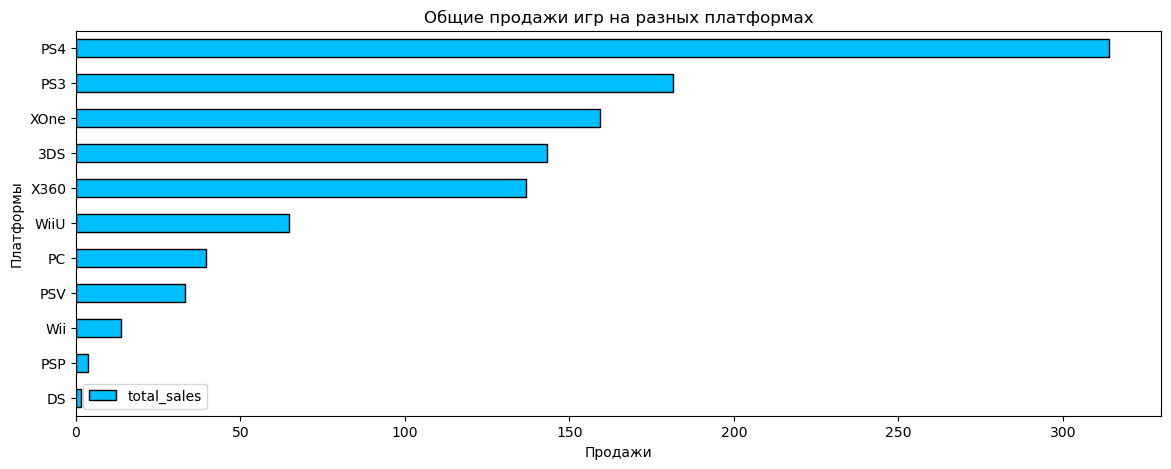

In [27]:
(df_act.groupby('platform')['total_sales']
.sum()
.reset_index()
.sort_values(by= 'total_sales')
.plot(kind='barh',x = 'platform', y='total_sales', figsize=(14,5), ec='black', color= 'deepskyblue'))

plt.title('Общие продажи игр на разных платформах')
plt.ylabel('Платформы')
plt.xlabel('Продажи')
plt.show()

##### Шаг 3.4 Платформы лидеры по продажам

Выберем 5 платформ с наибольшими продажами. Дальше анализировать будем их.

In [28]:
df_act_5 = df_act.groupby('platform')['total_sales'].sum().reset_index().sort_values(by= 'total_sales', ascending = False).head(5)
df_act_5.reset_index(drop=True)
df_act_5

,platform,total_sales
4,PS4,314.14
3,PS3,181.43
10,XOne,159.32
0,3DS,143.25
9,X360,136.80


In [29]:
act_5  = df_act_5['platform'].unique()
act_5

array(['PS4', 'PS3', 'XOne', '3DS', 'X360'], dtype=object)

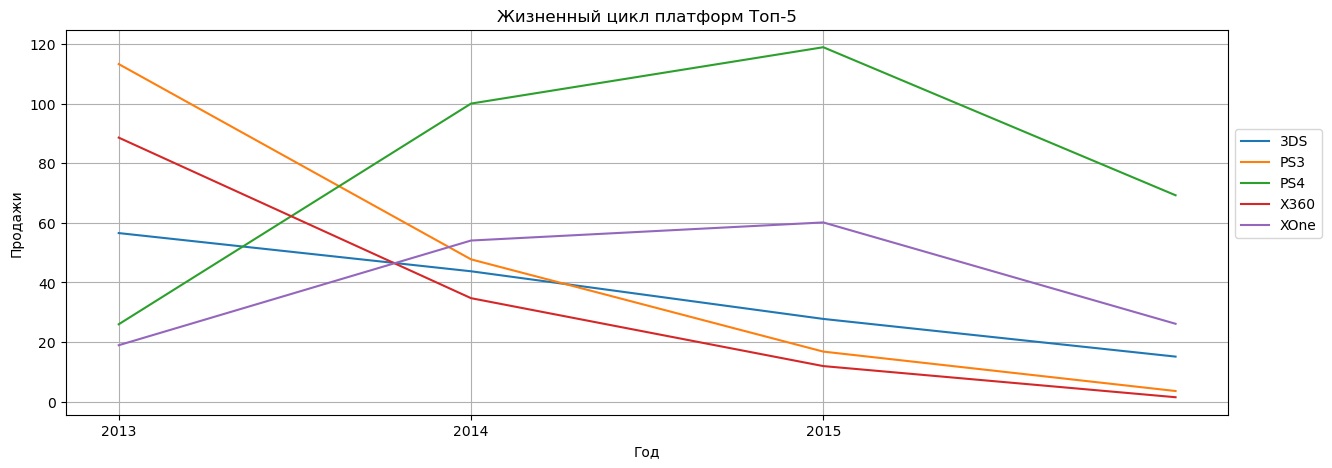

In [30]:
(df_act.query('platform in @act_5 and year_of_release >= 2013')
 .pivot_table(index='year_of_release', columns = 'platform', values='total_sales', aggfunc='sum')
 .plot(figsize=(15, 5)));
plt.grid(True)
plt.xticks(np.arange(2013,2016,1))
plt.title('Жизненный цикл платформ Топ-5')
plt.xlabel('Год')
plt.ylabel('Продажи')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.6));

На графике четко видно, что платформы PS3, X360, 3DS заканчивают свой жизненный цикл, их прибыль падает на протяжении последних 3 лет.<br/>
Платформы PS4 и XOne имеют потенциал для роста их жизненный цикл еще не завершается. 

##### Шаг 3.5 График «ящик с усами» по глобальным продажам игр в разбивке по платформам

In [31]:
df_act.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,303.0,0.472772,1.381347,0.01,0.0400,0.090,0.2800,14.60
DS,8.0,0.192500,0.172026,0.03,0.0675,0.150,0.2525,0.51
PC,189.0,0.208624,0.352304,0.01,0.0300,0.080,0.2300,3.05
PS3,345.0,0.525884,1.451939,0.01,0.0400,0.150,0.5100,21.05
PS4,392.0,0.801378,1.609456,0.01,0.0600,0.200,0.7300,14.63
PSP,67.0,0.052239,0.059768,0.01,0.0150,0.020,0.0700,0.24
PSV,358.0,0.092151,0.153816,0.01,0.0200,0.040,0.1100,1.96
Wii,23.0,0.593913,0.915432,0.01,0.0450,0.180,0.7550,3.58
WiiU,115.0,0.562000,1.038778,0.01,0.0600,0.200,0.5950,7.09


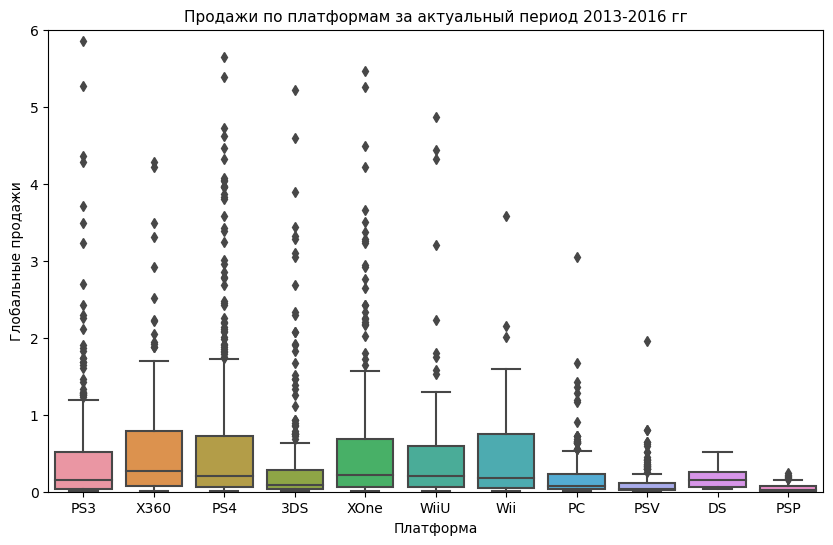

In [32]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_act, x='platform', y='total_sales')
plt.title('Продажи по платформам за актуальный период 2013-2016 гг', fontsize=11)
plt.ylim(0,6)
plt.xlabel('Платформа', fontsize=10)
plt.ylabel('Глобальные продажи',fontsize=10);

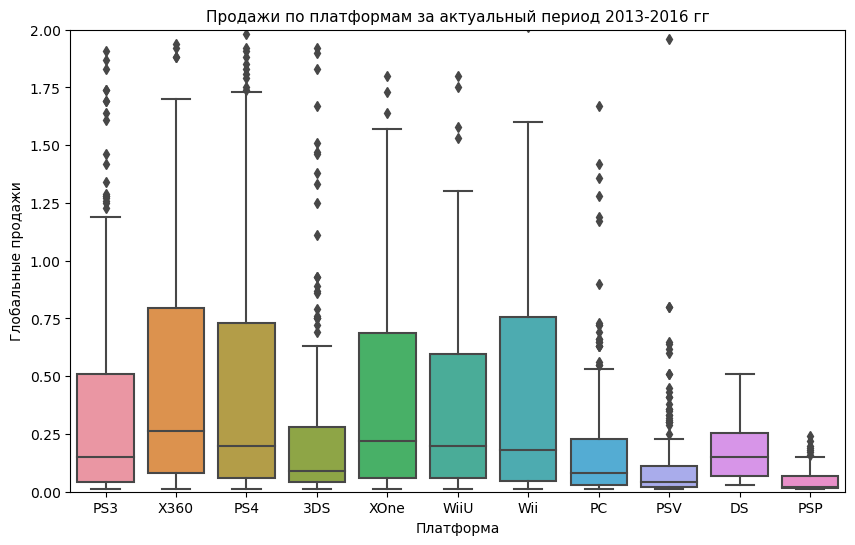

In [33]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_act, x='platform', y='total_sales')
plt.title('Продажи по платформам за актуальный период 2013-2016 гг', fontsize=11)
plt.ylim(0,2)
plt.xlabel('Платформа', fontsize=10)
plt.ylabel('Глобальные продажи',fontsize=10);

Описательная статистика и графики позволяют нам сделать выводы: медиана у всех платформ смещена к нижнему краю "ящика", это говорит о том, что на платформах выходит большое количество игр с относительно небольшими продажами. В тоже время мы видим большое количество выбросов почти у всех платформ - это игры, которые приносят максимальную прибыть платформам. Платформа PS4 стала лидером по совокупному доходу благодаря сочетанию факторов: у нее самое большое количество игр (392 шт.), а также больше всего топовых игр, приносящих большую долю доходов. У платформы X360 меньше, чем у PS4 игр (186 шт.), но наличие нескольких топовых игры с высоким доходом, а также немалое количество хорошо продаваемых самых разных игр (о чем говорит большой "ящик") вывели её в лидеры рынка по доходности. У платформы 3DS маленький "ящик" и короткие усы, но много выбросов, это говорит о том, что за счет выбросов формируется большая часть основной прибыли платформы.

##### Шаг 3.6 Влияние на продажи оценок критиков и пользователей

Для анализа влияния оценки критиков и пользователей на продажи выберем платформу PS4.<br/>
Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами по выбранной платформе.

In [34]:
df_ps = df.query('platform == "PS4" and year_of_release >= 2013')

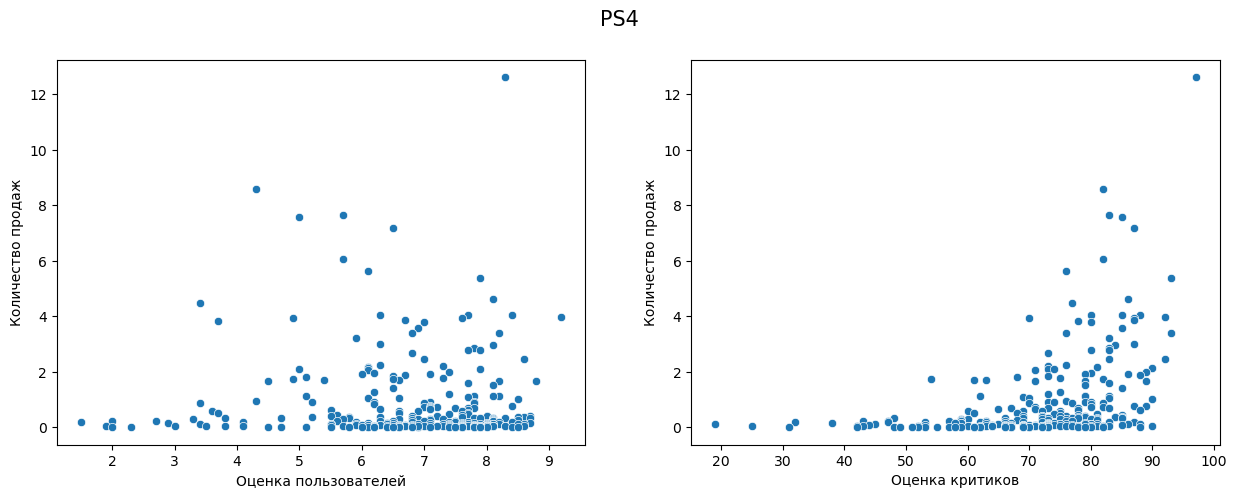

,total_sales,critic_score,user_score
total_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


In [35]:
fig, ax = plt.subplots(1 ,2, figsize=(15,5))
sns.scatterplot(x='user_score', y='total_sales', data=df_ps, ax=ax[0])
sns.scatterplot(x='critic_score', y='total_sales', data=df_ps, ax=ax[1])
fig.suptitle('PS4', fontsize=15)
ax[0].set(xlabel='Оценка пользователей')
ax[1].set(xlabel='Оценка критиков')
ax[0].set(ylabel='Количество продаж')
ax[1].set(ylabel='Количество продаж')
plt.show()

df_ps[['total_sales', 'critic_score', 'user_score']].corr()

На диаграмме рассеяния хорошо видно, что имеется определенная зависимость между оценкой критиков и продажами платформы. Чем выше оценка критиков, тем больше продажи. Коэффициент корреляции 0.4 подтверждает это.
В тоже время между оценкой пользователей и продажами нет прямой зависимости.

##### Шаг 3.7 Соотнесение выводов с продажами на других платформах

Выберем еще несколько платформ, построим по ним диаграмму рассеяния и посчитаем коэффициент корреляции, чтобы проверить сделанные нами на предыдущем шаге выводы.

In [36]:
df_pl = df.query('year_of_release >= 2013')

In [37]:
def platform_matrix(pl_name):
    platform = df_pl[df_pl['platform']==pl_name]
    fig, ax = plt.subplots(1 ,2, figsize=(15,5))
    sns.scatterplot(x='user_score', y='total_sales', data=platform, ax=ax[0])
    sns.scatterplot(x='critic_score', y='total_sales', data=platform, ax=ax[1])
    fig.suptitle(pl_name, fontsize=15)
    ax[0].set(xlabel='Оценка пользователей')
    ax[1].set(xlabel='Оценка критиков')
    ax[0].set(ylabel='Количество продаж')
    ax[1].set(ylabel='Количество продаж')
    plt.show()
    
    print(platform[['total_sales', 'critic_score', 'user_score']].corr())
    

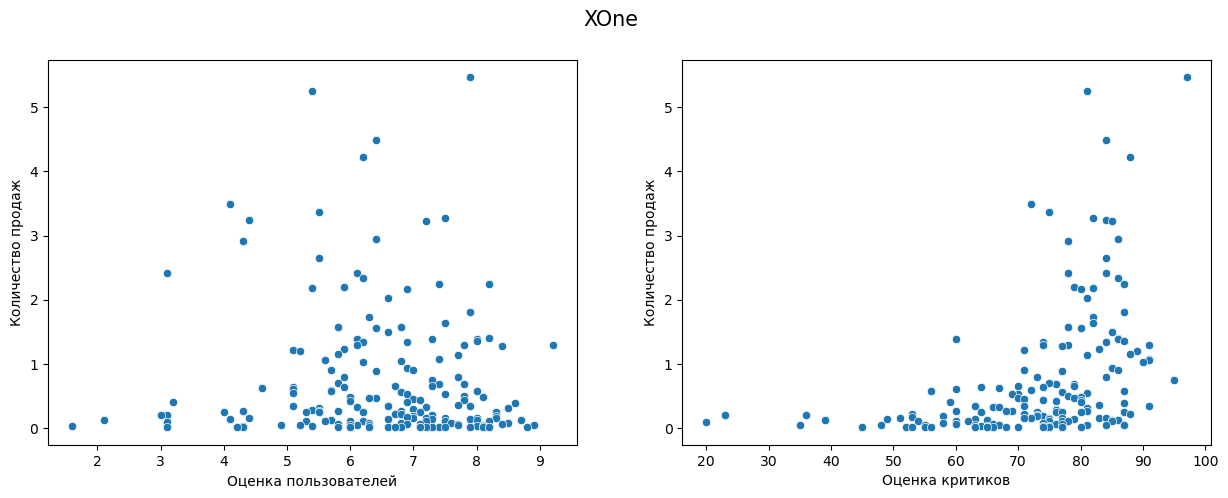

              total_sales  critic_score  user_score
total_sales      1.000000      0.416998   -0.068925
critic_score     0.416998      1.000000    0.472462
user_score      -0.068925      0.472462    1.000000


In [38]:
platform_matrix('XOne')

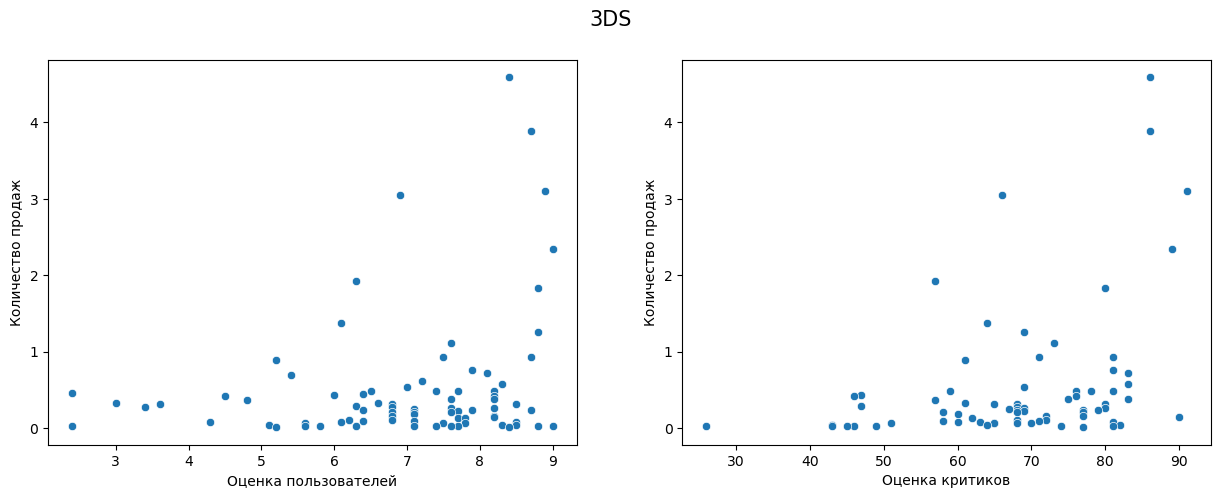

              total_sales  critic_score  user_score
total_sales      1.000000      0.357057    0.241504
critic_score     0.357057      1.000000    0.769536
user_score       0.241504      0.769536    1.000000


In [39]:
platform_matrix('3DS')

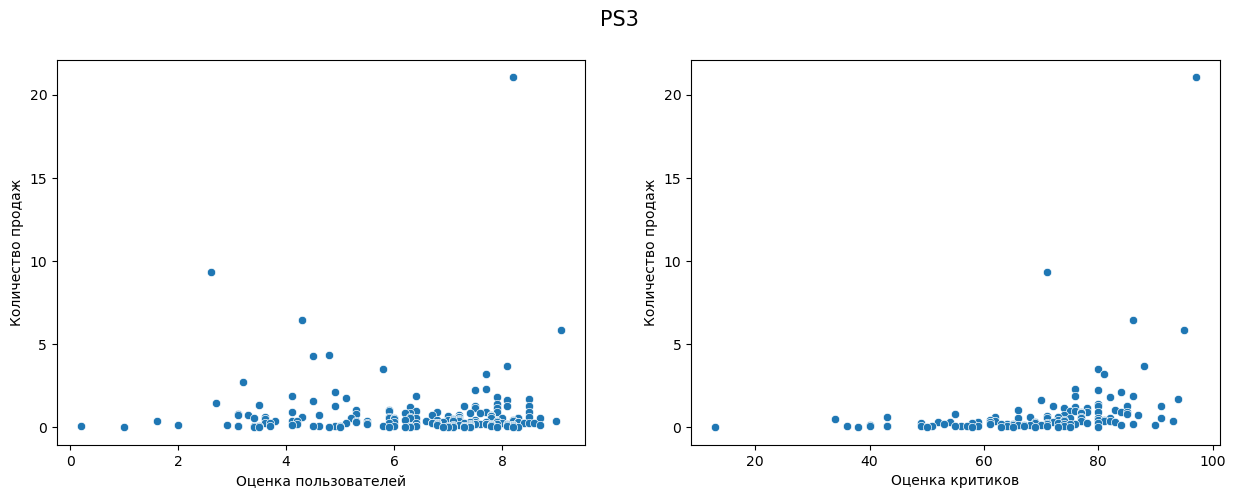

              total_sales  critic_score  user_score
total_sales      1.000000      0.334285    0.002394
critic_score     0.334285      1.000000    0.599920
user_score       0.002394      0.599920    1.000000


In [40]:
platform_matrix('PS3')

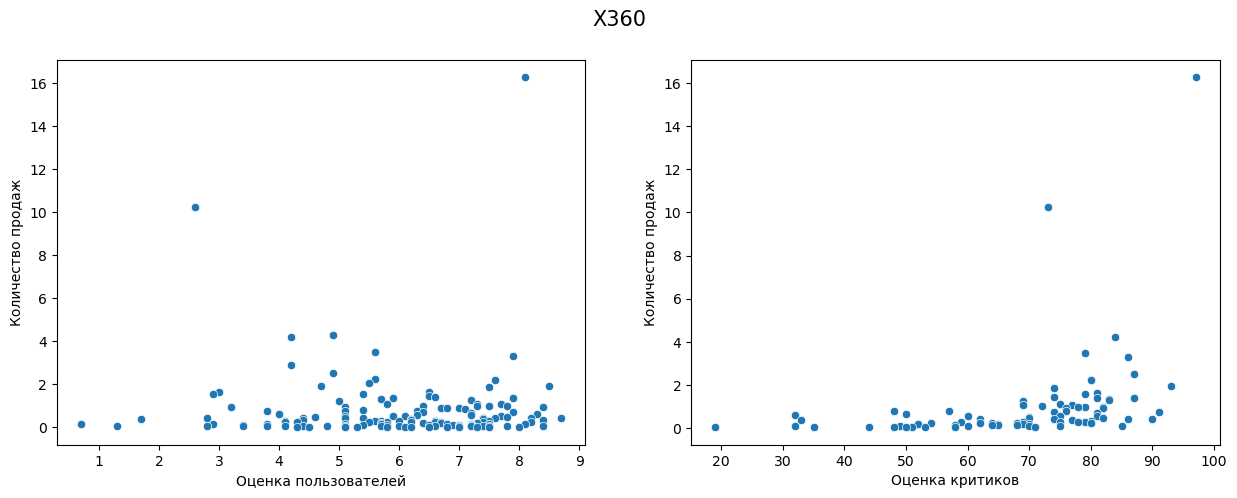

              total_sales  critic_score  user_score
total_sales      1.000000      0.350345   -0.011742
critic_score     0.350345      1.000000    0.520946
user_score      -0.011742      0.520946    1.000000


In [41]:
platform_matrix('X360')

Построенные нами диаграммы рассеяния подтверждают сделанные ранее выводы о наличии зависимости между оценкой критиков и продажами и отсутствием зависимости между оценкой пользователей и продажами. Самая выразительная картина получилась для второй растущей платформы XOne. Получается при покупке той или иной игры пользователи больше доверяют оценкам критиков, оценка же других пользователей практически не влияет на решение о покупке.

##### Шаг 3.8 Общее распределение игр по жанрам

Посмотрим на распределение продаж по жанрам игр.

In [42]:
df_g = df_pl.pivot_table(index = ['genre'], values = 'total_sales', aggfunc = ['count', 'sum']).reset_index()
df_g.columns = ['_'.join(col).strip() for col in df_g.columns.values]
df_g['ratio'] = round(df_g['sum_total_sales']/df_g['count_total_sales']*100,2)
df_g.columns = ['genre','count_sales','sum_sales','ratio']
df_g = df_g.sort_values(by = 'sum_sales', ascending = False)
df_g

,genre,count_sales,sum_sales,ratio
0,Action,766,321.87,42.02
8,Shooter,187,232.98,124.59
10,Sports,214,150.65,70.40
7,Role-Playing,292,145.89,49.96
3,Misc,155,62.82,40.53
4,Platform,74,42.63,57.61
6,Racing,85,39.89,46.93
2,Fighting,80,35.31,44.14
1,Adventure,245,23.64,9.65
9,Simulation,62,21.76,35.10


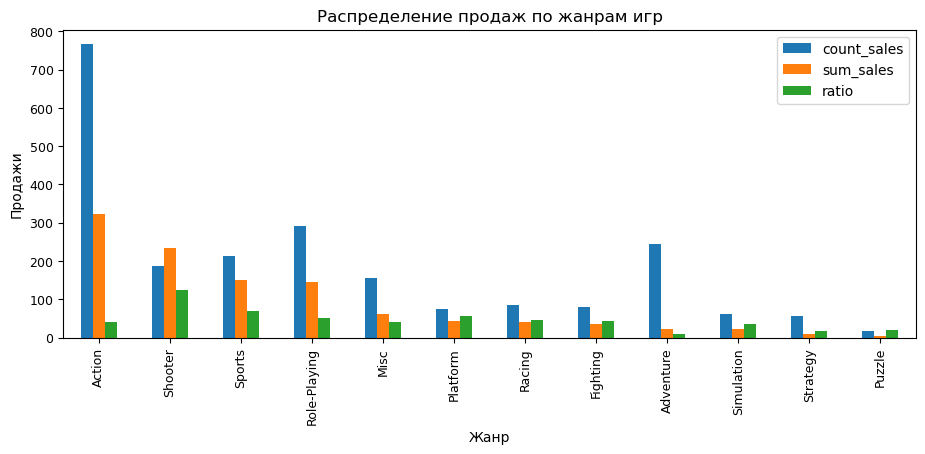

In [43]:
df_g.plot(x='genre', y=['count_sales', 'sum_sales', 'ratio'], kind='bar',figsize=(11,4), legend=True)
plt.title('Распределение продаж по жанрам игр')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.xlabel('Жанр')
plt.ylabel('Продажи')
plt.show()

Наибольшие валовые продажи показал жанр Action, но в этом жанре наибольшее число игр, таким образом конверсия игр в этом жанре не такая большой, даже не входит в топ-5. Игры в жанре Shooter имеют самую большую конверсию. Из общего ряда выделяется жанр Adventure, в этом жанре довольно таки много игр, но при этом конверсия очень низкая. Таким образом лидерами являются такие жанры как Shooter, Action, Sports. Аутсайдерами являются Adventure, Strategy, Puzzle.

**Выводы по шагу 3.** С 1980 по 1993 годы выходило малое количество игр. Начиная с 1994 года начинается устойчивый рост количества выпускаемых игр в год. Рост достигает своего пика в 2008 году, после чего происходит спад вплоть до 2016 года. Возможно спад связан с развитием мобильных технологий, а также социальных сетей, которые перетянули на себя внимание потенциальных пользователей.<br/>
Расчет медианной длины жизненного цикла платформ показал, что он составляет 7 лет. За этот период происходит резкий рост продаж в первые годы существования платформы, затем продажи достигают пика и потом происходит плавный спад.<br/>
В качестве актуального периода был выбран период с 2013 по 2016 год. Дальнейшее исследование велось по актуальному периоду.<br/>
В ходе анализа различных платформ нам удалось выбрать топ-5, которые показали наибольшие общие продажи за актуальный период. Среди топ-5 мы выделили 2 с потенциалом для роста PS4 и XOne, а также 3 платформы продажи по которым падают - PS3, X360, 3DS.<br/>
Платформа PS4 стала лидером по совокупному доходу благодаря сочетанию факторов: у нее самое большое количество игр (392 шт.), а также больше всего топовых игр, приносящих большую долю доходов.<br/>
В ходе анализа связи между оценками критиков и пользователей и доходностью платформы мы установили, что при покупке той или иной игры пользователи больше доверяют оценкам критиков, оценка же других пользователей практически не влияет на решение о покупке.<br/>
Что касается доходности игр в зависимости от жанра, то лидерами оказались Shooter, Action, Sports, а наихудший результат показали Adventure, Strategy, Puzzle.

#### Шаг 4. Портрет пользователя каждого региона

##### Шаг 4.1 Топ-5 платформ по регионам

In [44]:
def top_regions(groupby, region_sales, ax):
    pivot = df_pl.groupby(groupby)[region_sales].agg('sum').sort_values(ascending=False)[:5]
    title_dict = {'na_sales': 'Северная Америка', 'eu_sales': 'ЕС', 'jp_sales': 'Япония'}
    color_dict = {'na_sales': 'lightcoral', 'eu_sales': 'lightseagreen', 'jp_sales': 'lightskyblue'}
    plot = pivot.plot(kind='bar', ec='black', title=title_dict[region_sales], ax=axes[ax], fontsize=18, color=color_dict[region_sales], rot=20)
    plot.legend(prop={'size':17})
    plot.set_xlabel('Платформа', fontsize=15)
    plot.set_ylabel('Продажи', fontsize=15)
    plot.title.set_size(20)

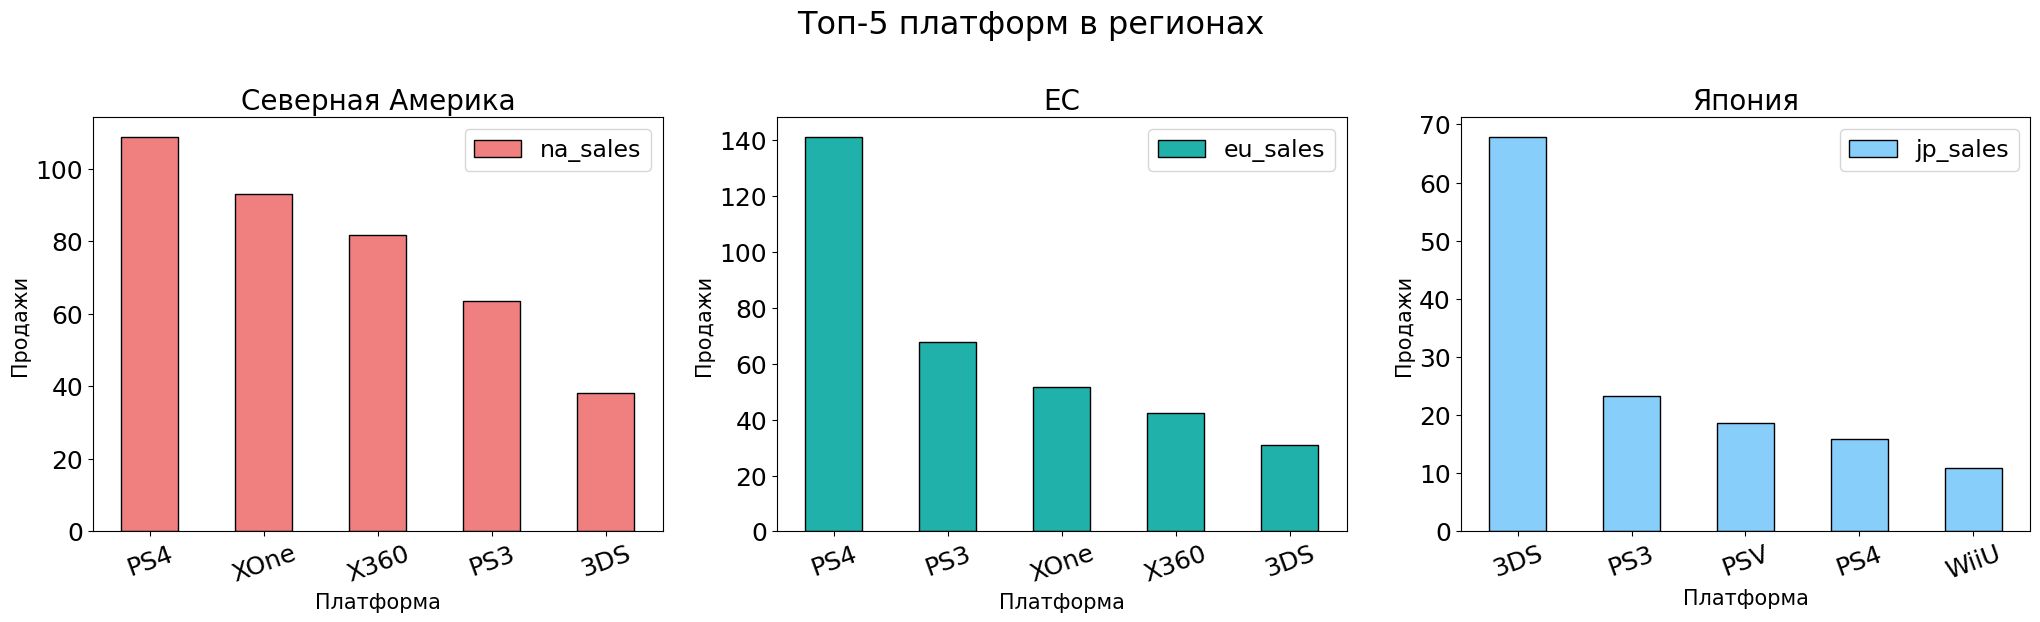

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))
fig.suptitle('Топ-5 платформ в регионах', fontsize=23)
plt.subplots_adjust(top = 0.8)
top_regions('platform', 'na_sales', 0)
top_regions('platform', 'eu_sales', 1)
top_regions('platform', 'jp_sales', 2)

В Северной Америке и Европей на первом месте по доходности находится платформа PS4, в то время, как в Японии лидером является - 3DS, более старая платформа, которая в NA и EU занимает последнее место из Топ-5.
XOne на втором и третьем месте по прибыльности в Северной Америке и Европе соответственно, в Японии данная платформа вообще не вошла в Топ-5.
С платформой X360 ситуация схожая с XOne: в Америке и Европей - 3 и 4 место, в Японии - не вошла в топ.
Интересная ситуация с платформой PS3 (одной из самых старых в наших рейтингах), в Америке она на 4 месте по доходности, а в Европе и Японии удерживает 2 место.
Таким образом можно сделать вывод, что пользователи Америки довольно быстро переключаются на новинки, которые начинают получать наибольшую долю прибыли.<br/>
Европейские пользователе чуть более консервативны, не забывают старые популярные платформы, но в тоже время открыты общемировым лидерам.<br/>
Японские пользователи самые консервативные, они больше всего привержены платформе, выпущенной в их стране (3DS), хоть она и не самая новая. Также в Японии популярна более старая версия мирового лидера (PS3).

##### Шаг 4.2 Топ-5 жанров по регионам

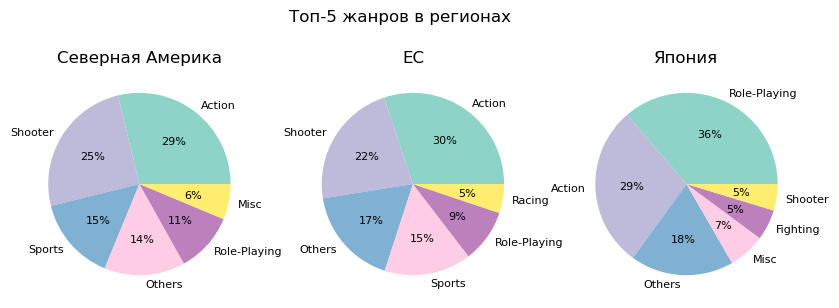

In [46]:
def top_genre(groupby, region_sales, ax):
    pivot_g = df_act.groupby(groupby)[region_sales].agg('sum').sort_values(ascending=False)
    pivot_g.loc['Others'] = pivot_g.iloc[5:].sum()
    pivot_g = pivot_g.sort_values(ascending = False)[:6]
    title_dict = {'na_sales': 'Северная Америка', 'eu_sales': 'ЕС', 'jp_sales': 'Япония'}
    labels = ['genre']
    plot = pivot_g.plot(kind='pie', autopct='%1.0f%%', legend=False, 
                        figsize=(10, 10), title=title_dict[region_sales], 
                        ax=axes[ax],cmap='Set3', textprops={'fontsize': 8})
    plot.set_ylabel('')
  
fig, axes = plt.subplots(1, 3, figsize=(25,5))
fig.suptitle('Топ-5 жанров в регионах')
plt.subplots_adjust(top= 1.5)
top_genre('genre', 'na_sales', 0)
top_genre('genre', 'eu_sales', 1)
top_genre('genre', 'jp_sales', 2)

В Северной Америке и Европе самыми прибыльными являются экшены и шутеры. В Японии же шутеры в конце списка топ-5. Лидерами в Японии являются ролевые игры. Скорее всего такие различия связаны с культурными, религиозными, историческими особенностями каждой страны; с традициями и менталитетом ее жителей.

##### Шаг 4.3 Влияние рейтинга ESRB на продажи в отдельном регионе

Рейтинг ESRB определяет наиболее подходящую возрастную категорию для игры. Построим графики продаж игр по рейтингам в каждом регионе.

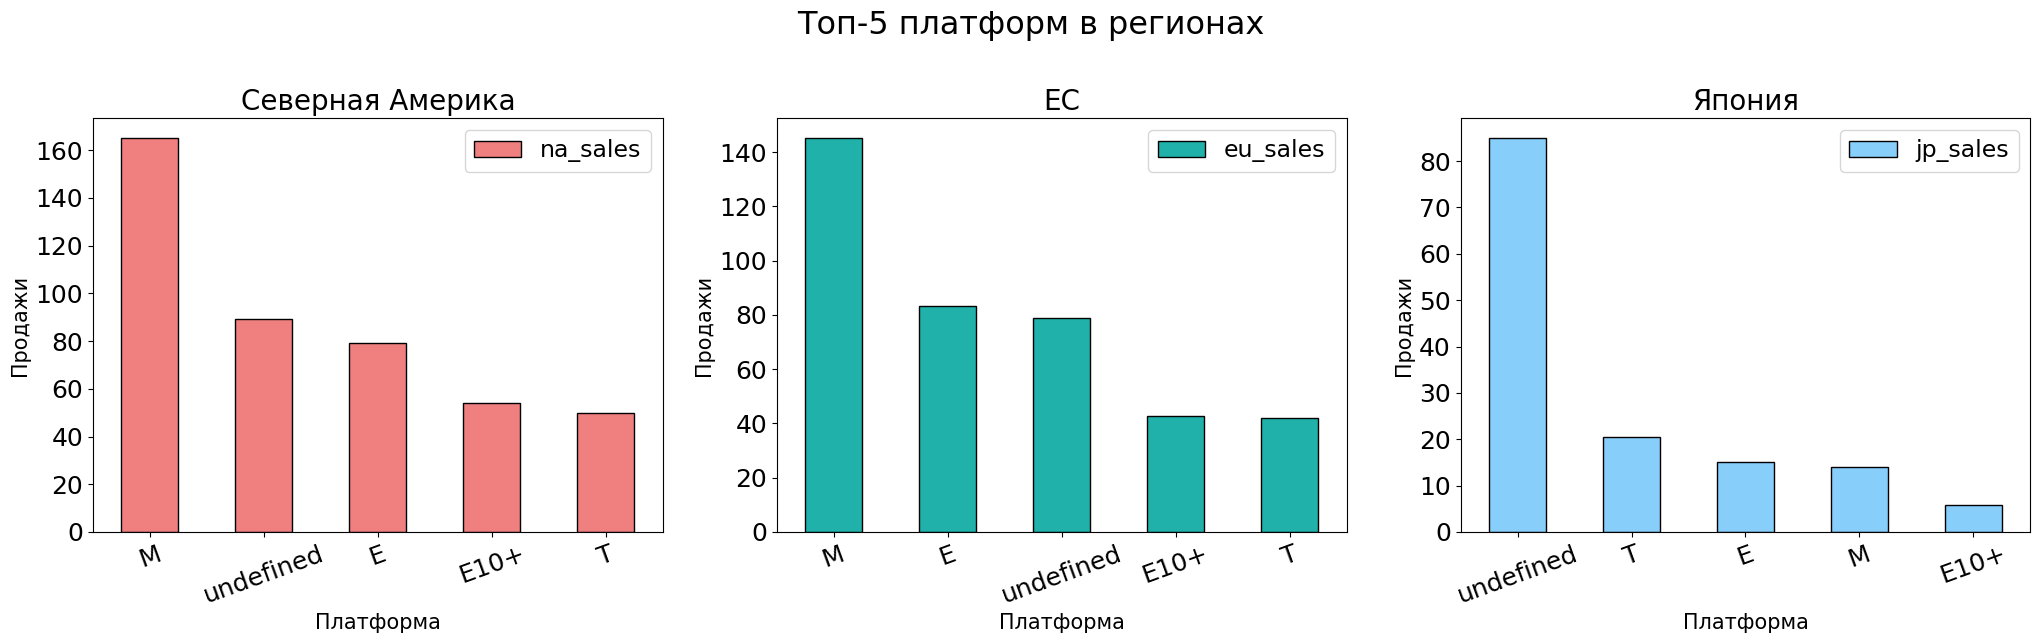

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))
fig.suptitle('Топ-5 платформ в регионах', fontsize=23)
plt.subplots_adjust(top = 0.8)
top_regions('rating', 'na_sales', 0)
top_regions('rating', 'eu_sales', 1)
top_regions('rating', 'jp_sales', 2)

В Америке и Европе самыми прибыльными являются игры для взрослых (М), в Японии они на 4 месте.
Игры для всех (Е) популярны во всех регионах и занимают 2-3 места.
Игры для всех с 10 лет (Е10+) находятся на 4 месте в Америке и Европе, в Японии они на 5 месте.
Группа игр с неопределенным рейтингом, также очень популярна: 2 место в Европе и Америке и самые популярные в Японии. Возможно в Японии наиболее популярны игры, созданные для местного рынка, и они не рейтингуются. Также в Японии популярны игры для подростков от 13 лет (Т), в то время, как в двух других регионах они на последнем месте топ-5.

**Выводы по шагу 4.** На этом шаге были выявлены региональные различия в предпочтениях пользователей относительно консольных игр. 
В Северной Америке пользователи отдают предпочтение более новым платформам - общемировым лидерам (PS4, XOne), из жанров они предпочитают шутеры и экшены, что касается возрастной категории игр, то здесь лидеры - это игры для взрослых.<br/>
Европейские пользователи очень похожи на американских, есть небольшие отличия относительно популярности платформ. В Европе все еще очень популярна платформа PS3, хотя она вышла еще в 2006 году.
В Японии предпочтения пользователей оказались непохожими на других. Из платформ японцы чаще выбирают не самую новую, но созданную в Японии (3DS), из жанров популярны ролевые игры, наличие или отсутствие рейтинг ESRB не влияет на выбор японцев, т.к. среди лидеров у них игры без этого рейтинга.

#### Шаг 5. Проверка гипотезы

#### Шаг 5.1 Проверка гипотезы о платформах

Сформулируем нулевую и альтернативную гипотезы:<br>
**Гипотеза H_0:** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. <br>
**Гипотеза H_1:** Средние пользовательские рейтинги платформ Xbox One и PC отличаются. <br>
alpha = 0.05

Для проверки гипотезы будем использовать t-критерий Стьюдента, т.к. он используется, когда генеральные совокупности не зависят друг от друга.

In [48]:
df_xone = df_pl[df_pl['platform']=="XOne"]['user_score'].dropna()
df_pc = df_pl[df_pl['platform']=="PC"]['user_score'].dropna()

In [49]:
alpha = 0.05 # уровень стат. значимости

results = st.ttest_ind(df_xone, df_pc)

# выведем на экран получившееся p-значение
print('p-значение:', results.pvalue)

if results.pvalue < alpha: # сравним получившееся p-значение с alpha
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


Посчитаем средние значения по нашим выборкам, чтобы убедиться в непротиворечивости наших гипотез. 

In [50]:
print(df_xone.mean())
df_pc.mean()

6.521428571428572


6.2696774193548395

Не получилось отвергнуть нулевую гипотезу, следовательно можно утверждать, что **средний пользовательский рейтинги платформ Xbox One и PC равны.**

#### Шаг 5.2 Проверка гипотезы о жанрах

Сформулируем нулевую и альтернативную гипотезы:<br>
**Гипотеза H_0:** Средние пользовательские рейтинги жанров Action и Sports одинаковые. <br>
**Гипотеза H_1:** Cредние пользовательские рейтинги жанров Action и Sports отличаются. <br>
alpha = 0.05

Для проверки гипотезы будем использовать t-критерий Стьюдента, т.к. он используется, когда генеральные совокупности не зависят друг от друга.

In [51]:
df_action = df_pl[df_pl['genre']=="Action"]['user_score'].dropna()
df_sports = df_pl[df_pl['genre']=="Sports"]['user_score'].dropna()

In [52]:
alpha = 0.05 # уровень стат. значимости

results = st.ttest_ind(df_action, df_sports, equal_var = False)

# выведем на экран получившееся p-значение
print('p-значение:', results.pvalue)

if results.pvalue < alpha: # сравним получившееся p-значение с alpha
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


Нулевая гипотеза не подтвердилась, значит **средние пользовательские рейтинги жанров Action и Sports отличаются**.

Посчитаем средние значения по нашим выборкам, чтобы убедиться в непротиворечивости наших гипотез. 

In [53]:
print(df_action.mean())
df_sports.mean()

6.837532133676092


5.238124999999999

**Вывод по шагу 5.** Проверка гипотезы о равенстве среднего пользовательского рейтинга платформ XOne и PC, подтвердила , что эти рейтинги равны. Гипотезу о равенстве средних пользовательских рейтингов жанров Action и Sports мы отвергли, эти рейтинги не равны.

#### Общий вывод

В ходе исследовательского анализ продаж компьютерных игр для интернет-магазина проделаны следующие работы:
- Произведено первичное ознакомление с данными, в некоторых столбцах обнаружены пропуски (например, year_of_release, critic_score и п.т.), а также неверно определены типы данных (например, year_of_release), в наименованиях столбцов встречаются строчные и заглавные буквы.
- Выполнена предобработки данных: проанализированы данные на наличие явных дубликатов (их не оказалось) и неявных дубликатов (их оказалось 4 шт., они были удалены). Пропуски с числовыми рейтингами оставили как есть, пропуски в столбце с категориальными данными (столбец rating) заменены на 'undifend'. Типы данных были скорректированы у столбцов year_of_release и user_score.
- Проведен исследовательский анализ данных, в ходе которого выяснилось, что до 1994 годы выходило малое количество игр, начиная с 1994 года начался устойчивый рост количества выпускаемых игр в год. Рост достиг своего пика в 2008 году, после чего произошел спад вплоть до 2016 года. Расчет средней длины жизненного цикла платформ показал, что он составляет 11 лет. За этот период происходит резкий рост продаж в первые годы существования платформы, затем продажи достигают пика и потом происходит плавный спад на протяжении 6-8 лет. В качестве актуального периода был выбран период с 2013 по 2016 год. Дальнейшее исследование велось по актуальному периоду.
В ходе анализа различных платформ удалось выбрать топ-5, которые показали наибольшие общие продажи за актуальный период. Среди топ-5 выделили 2 с потенциалом для роста PS4 и XOne, а также 3 платформы продажи по которым падают - PS3, X360, 3DS.
В ходе анализа связи между оценками критиков и пользователей и доходностью платформы установили, что при покупке той или иной игры пользователи больше доверяют оценкам критиков, оценка же других пользователей практически не влияет на решение о покупке.
Что касается доходности игр в зависимости от жанра, то лидерами оказались Shooter, Action, Sports, а наихудший результат показали Adventure, Strategy, Puzzle.
- Выявлены региональные различия в предпочтениях пользователей относительно консольных игр. В Северной Америке пользователи отдают предпочтение более новым платформам - общемировым лидерам (PS4, XOne), из жанров они предпочитают шутеры и экшены, что касается возрастной категории игр, то здесь лидеры - это игры для взрослых.<br/>
Европейские пользователи очень похожи на американских, есть небольшие отличия относительно популярности платформ. В Европе все еще очень популярна платформа PS3, хотя она вышла еще в 2006 году.
В Японии предпочтения пользователей оказались непохожими на других. Из платформ японцы чаще выбирают не самую новую, но созданную в Японии (3DS), из жанров популярны ролевые игры, наличие или отсутствие рейтинг ESRB не влияет на выбор японцев, т.к. среди лидеров у них игры без этого рейтинга.
 - Проверена гипотезы о равенстве среднего пользовательского рейтинга платформ XOne и PC. Тест подтвердил, что эти рейтинги равны. Гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports была отвергнута, эти рейтинги не равны.
 
 В результате исследования возможно дать рекомендации отделу рекламы: регионом, который приносит наибольшие доходы является Северная Америка, здесь самой популярной платформой выступает PS4, самый востребованный жанр - это шутеры, что касается возрастных категорий игр, то больше дохода приносят игры для взрослых. Оценки критиков оказывают влияние на прибыль от игр, но влияние это слабое; мнения пользователей на продажи не влияет. Целесообразным представляется потратить рекламный бюджет на игры обладающие описанными характеристиками.